In [1]:
!python -m spacy download en_core_web_sm

2022-04-04 10:55:12.885370: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-04 10:55:12.885508: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
     |████████████████████████████████| 13.9 MB 14.5 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import pandas as pd
import numpy as np

import nltk

from sklearn.metrics import classification_report

import os

from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import spacy
import re
import emoji
import pickle
import string
from joblib import dump, load

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
nltk.download('punkt')

nlp = spacy.load("en_core_web_sm")
df = pd.read_csv("data.csv", encoding="unicode_escape")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Function to remove @names and special character
def punc_clean(text):
    text= ' '.join(re.sub('(@[A-Za-z0-9_]+)|(&[A-Za-z0-9_]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)|(["“)#!?”(-.%&$,*/;:<>=\/|^`{}~])' , " ", text).split())
    text = re.sub('[0-9]+', '', text)
    text = re.sub('['+string.punctuation+']', '', text)
    return text

def replace_name(text): 
    # Convert these @pfizer, @sinovac, @moderna_tx, @sputnikvaccine to normal form pfizer/sinovac/moderna/sputnik
    vaccine_dict = {"@pfizer": "pfizer",
                    "@sinovac": "sinovac",
                   "@moderna_tx": "moderna",
                   "@sputnikvaccine": "sputnik"}
    
    for key in vaccine_dict:
        if key in text:
            text = text.replace(key, vaccine_dict[key])
    
    return text

def space(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

def preprocess(data):
    data['tweet_text'] = data['tweet_text'].apply(replace_name)
    data['tweet_text'] = data['tweet_text'].apply(lambda x: x.lower())
    data['tweet_text'] = data['tweet_text'].apply(lambda x: emoji.demojize(x))
    data['tweet_text'] = data['tweet_text'].str.encode('ascii', 'ignore').str.decode('ascii')
    data['tweet_text'] = data['tweet_text'].apply(space)
    data['tweet_text'] = data['tweet_text'].apply(punc_clean)

    has_duplicate = data.duplicated(subset = ['tweet_text']).any()
    if has_duplicate:
        data.drop_duplicates(subset = ['tweet_text'], inplace = True)
        
    return data

In [5]:
def vectorize(data, tfidf_vect_fit):
    X_tfidf = tfidf_vect_fit.transform(data)
    words = tfidf_vect_fit.get_feature_names_out()
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
    X_tfidf_df.columns = words
    return(X_tfidf_df)

In [6]:
df = preprocess(df)

X_data = df[['tweet_text']].to_numpy().reshape(-1)
Y_data = df[['sentiment']].to_numpy().reshape(-1)

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size = 0.2, random_state = 42)

In [7]:
tfidf_vect = TfidfVectorizer(analyzer = 'word')
tfidf_vect_fit = tfidf_vect.fit(X_train)
X_train = vectorize(X_train, tfidf_vect_fit)

In [8]:
with open('tfidf_2.pickle', 'wb') as write_file:
    pickle.dump(tfidf_vect_fit, write_file, protocol = pickle.HIGHEST_PROTOCOL)

In [9]:
rfClf = RandomForestClassifier(n_estimators = 200) # 200 trees. 
svmClf = SVC(probability = True, random_state = 0) # probability calculation
logClf = LogisticRegression(random_state = 0, max_iter = 200)

clf2 = VotingClassifier(estimators = [('rf', rfClf), ('svm', svmClf), ('log', logClf)], voting = 'soft')

In [10]:
# Train the ensemble classifier
clf2.fit(X_train, Y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(n_estimators=200)),
                             ('svm', SVC(probability=True, random_state=0)),
                             ('log',
                              LogisticRegression(max_iter=200,
                                                 random_state=0))],
                 voting='soft')

In [11]:
dump(clf2, "Ensemble_2.joblib")

['Ensemble_2.joblib']

In [12]:
X_test = vectorize(X_test, tfidf_vect_fit)
Y_pred = clf2.predict(X_test)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           1       0.66      0.20      0.31       245
           2       0.67      0.90      0.77       954
           3       0.69      0.44      0.53       461

    accuracy                           0.67      1660
   macro avg       0.67      0.51      0.54      1660
weighted avg       0.67      0.67      0.64      1660



In [13]:
from sklearn.metrics import accuracy_score

print(accuracy_score(Y_test, Y_pred))

0.6704819277108434


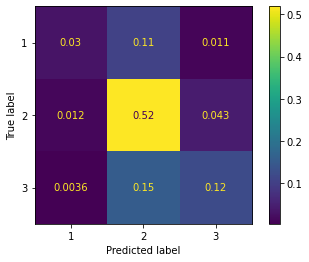

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    Y_test,
    Y_pred,
    normalize = 'all'
)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0a860f2d-c036-4b61-8b0f-a2fa5b54fb03' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>